In [2]:
import sys
sys.path.append("../build")
import SBTimeSeries

'''
For Linux users: replace what is above by
sys.path.append("../build")
import SBTimeSeries
'''

import time
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import date
from scipy.stats import ks_2samp, kstest, kurtosis
import yfinance as yf
yf.pdr_override()
from fbm import FBM
from tensorflow.keras.datasets import mnist
from pathlib import Path
import os
import warnings
warnings.filterwarnings("ignore")

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


2024-06-19 14:17:05.684212: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 14:17:07.009342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from src.schrodinger_bridge import SchrodingerBridge

## Schätzung der Drift-Funktion mit dem Nadaraya-Watson-Schätzer und Kernel-Methoden

Nadaraya-Watson-Schätzer:

$$
\hat{a}(t, x; x_i) = \frac{1}{t_{i+1} - t} \frac{\sum_{m=1}^{M} (X_{t_{i+1}}^{(m)} - x) F_i(t, X_{t_i}^{(m)}, x, X_{ t_{i+1}}^{(m)}) \prod_{j=1}^{i} K_h(x_j - X_{ t_j}^{(m)})}{\sum_{m=1}^{M} F_i(t, X_{t_i}^{(m)}, x, X_{ t_{i+1}}^{(m)}) \prod_{j=1}^{i} K_h(x_j - X_{ t_j}^{(m)})},
$$

mit $F_i(t, x_{i}, x, x_{i+1}) = \exp \left( -\frac{|x_{i+1} - x|^2}{2(t_{i+1} - t)} + \frac{|x_{i+1} - x_i|^2}{2(t_{i+1} - t_i)} \right)$.
 
In der Methode `simulate_kernel` wird der Nadaraya-Watson-Schätzer verwendet, um die Drift-Funktion zu approximieren. Dieser Schätzer basiert auf einer Kernel-Methode, die es ermöglicht, die bedingten Erwartungswerte unter der Zielverteilung $\mu$ direkt aus Datenproben zu schätzen. Die Kernel-Methode verwendet entweder den Quartic-Kernel oder den Gausschen Kernel.

Der Quartic-Kernel wird durch die Funktion

$K_h(x) = \frac{1}{h}K\left(\frac{x}{h}\right)$

mit

$K(x) = \begin{cases} (1 - |x|^2)^2 & \text{falls } |x| \leq 1 \\ 0 & \text{falls } |x| > 1 \end{cases}$

definiert. Dieser Kernel ermöglicht eine adaptive Anpassung der Gewichtungen der Datenproben, wobei $h$, der Abstand zwischen den Datenpunkten, berücksichtigt wird.

Der Gaussche Kernel wird durch die Funktion

$K(x) = \frac{1}{\sqrt{2\pi}H} \exp\left(-\frac{x^2}{2H^2}\right)$

gegeben, wobei $H$ die Varianzparameter ist. Dieser Kernel modelliert die Gewichtungen der Datenproben unter Berücksichtigung der Normalverteilung.


## Simulation der Schrödinger-Brücke

Die Funktion `simulateSB` dient dazu, eine Schrödinger-Brücke zu simulieren. Dabei werden folgende Parameter verwendet:
- `N`: Die Anzahl der Zeitintervalle.
- `M`: Die Anzahl der Pfade.
- `Data`: Die Datenmatrix der beobachteten Zeitreihen.
- `deltati`: Die Zeitschrittweite.
- `H`: Die Varianzparameter für den Kernel.
- `nbStepsPerDeltati`: Die Anzahl der Schritte pro Zeitschritt.
- `numberOfSamples`: Die Anzahl der zu simulierenden Brücken.

Die Funktion erstellt eine Instanz der Klasse `SchrodingerBridge` mit den angegebenen Parametern und führt dann die Simulation der Schrödinger-Brücke durch. Die resultierende Simulation wird als Numpy-Array zurückgegeben.


In [22]:
def simulateSB(N, M, Data, deltati, H, nbStepsPerDeltati, numberOfSamples):
    assert Data.shape == (M, N+1)
    assert H > 0
    
    simulator = SchrodingerBridge(N, M, Data)

    simu = []
    for i in tqdm(range(numberOfSamples)):
        simu.append(simulator.simulate_kernel(nbStepsPerDeltati, H, deltati))
    simu = np.array(simu)
    
    return simu

## Generierung einer Zeitreihe

Eine Zeitreihe wird gemäß eines autoregressiv integrated moving average (ARIMA) Modells generiert. 

Hier wird ein ARIMA(2,0,1) mithilfe von statsmodels simuliert.


Für die Simulation werden Datensätze der Größe $M = 1000$ für das AR-Modell verwendet. Die Drift-Funktion der Schrödinger-Brücke wird mit einem Kernel
mit einer Bandbreite von $H = 0.05$ geschätzt und mithilfe des Euler-Verfahrens mit $N^{\pi} = 100$ simuliert.


In [248]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Settings
M = 1000  # Number of data points
N = 3     # Number of steps

# Generate data
X = np.zeros((M, N))
X[:, 0] = np.random.normal(size=M)
for i in range(1, N):
    X[:, i] = 0.5 * X[:, i-1] + np.random.normal(size=M)

# Fit ARIMA(2, 0, 1) model
arima_model = ARIMA(pd.Series(X[:, 0]), order=(2, 0, 1))
arima_model_fit = arima_model.fit()

# Generate additional time steps using the ARIMA process
for i in range(N-1):
    arima_model = ARIMA(pd.Series(X[:, i]), order=(2, 0, 1))
    arima_model_fit = arima_model.fit()
    X_next = arima_model_fit.forecast().values.reshape((1, 1))  # Convert to NumPy array and reshape to (1, 1)
    X_next_tiled = np.tile(X_next, (M, 1))  # Repeat X_next M times along the first dimension
    X = np.hstack((X, X_next_tiled))

# Normalize the time series
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Print the shape of X

X_temp = np.zeros((M,N+1))
X_temp[:,1:] = X[:,:3]
X = X_temp
print(f"Shape of X: {X.shape}")

Shape of X: (1000, 4)


In [6]:
print(f"Number of samples {M},\nShape of the Data: {X.shape},\nNumber of X_{'t_1'},...,X_{'t_N'}, N={X.shape[1]-1} ")

Number of samples 1000,
Shape of the Data: (1000, 4),
Number of X_t_1,...,X_t_N, N=3 


## Simulation der Schrödinger-Brücke

Es wird eine Schrödinger-Brücke simuliert mit folgenden Parametern:
- Anzahl der Zeitintervalle: $N = 3$
- Anzahl der Proben: $M = 1000$
- Beobachtete Datenmatrix: $X$
- Zeitschrittweite: $\frac{7}{252}$
- Varianzparameter für den Kernel: $H = 0.05$
- Anzahl der Schritte pro Zeitschritt: $100$
- Anzahl der zu simulierenden Brücken: $1000$

In [7]:
# Simulate
simu = simulateSB(
    N=N, 
    M=M,
    Data=X, 
    deltati=7./252., 
    H=0.05, 
    nbStepsPerDeltati=100, 
    numberOfSamples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
print(f"Shape of the Data: {X.shape},\nShape of the simulated Data: {simu.shape}")

Shape of the Data: (1000, 4),
Shape of the simulated Data: (1000, 4)


Text(0.5, 1.0, 'Time Series $X_{t_3}$: Data vs. SBTS')

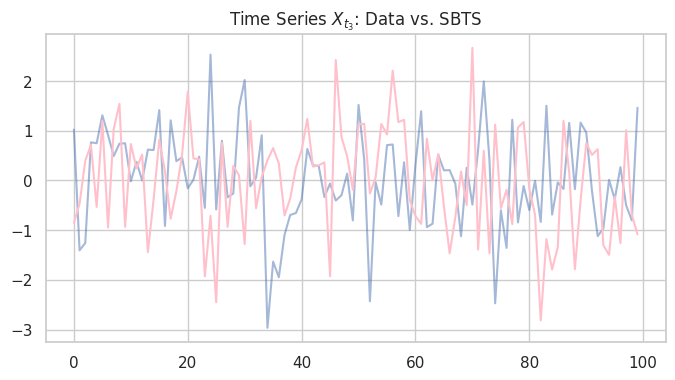

In [19]:
plt.figure(figsize=(8,4))
plt.plot(simu[:100,3], label='SBTS', alpha=0.5)
plt.plot(X[:100,3], label='Data', color='pink')
plt.title('Time Series $X_{t_3}$: Data vs. SBTS')

### Verteilungsplot

Es wird ein gemeinsamer Verteilungsplot für die Zufallsvariablen $X_{t_i}$ und $X_{t_j}$, wobei $i,j\in \{1,2,3\}$ erstellt. Dabei werden die echten Daten und die simulierten Daten der Schrödinger-Brücke dargestellt. Die Konturdiagramme zeigen die Dichteschätzungen der Verteilungen.

In [10]:
K = 500 # Last K elements

last_X = X[:K,:]
last_simu = simu[:K,:]

combined_data = np.concatenate((last_X, last_simu), axis=0)
combined_data.shape
column_names = [f"X_{i}" for i in range(4)]
df = pd.DataFrame(combined_data, columns=column_names)


df["Type"] = ["Data"] * 500 + ["SBTS"] * 500

# Print the DataFrame
df = df.drop('X_0',axis=1)

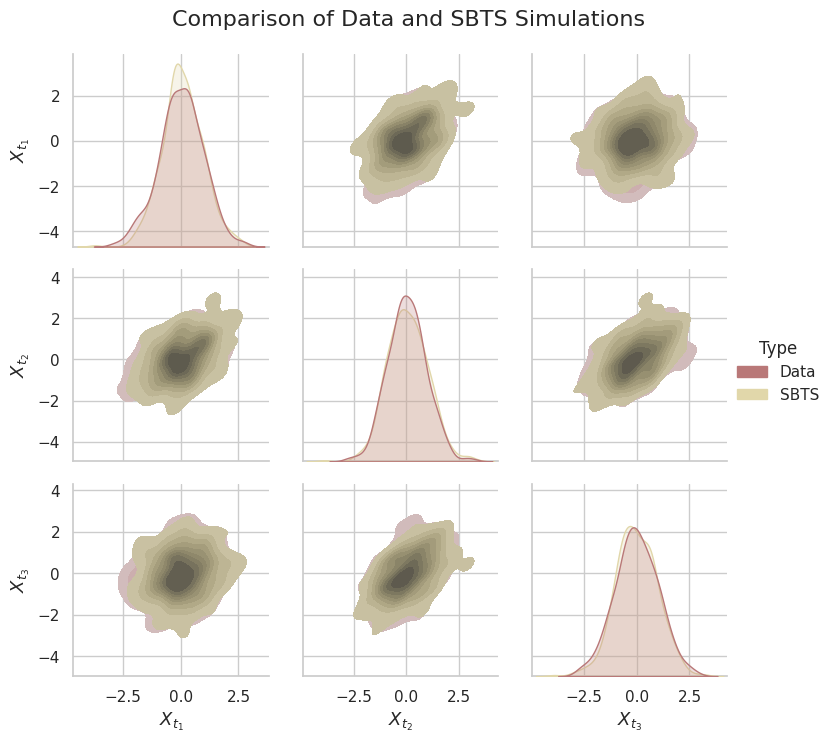

In [183]:
# Create a PairGrid
g = sns.PairGrid(df, hue='Type', palette='pink')

# Map the plots to the grid
g.map_upper(sns.kdeplot, fill=True)  # Use scatter plot for the upper triangle
g.map_lower(sns.kdeplot, fill=True)  # Use filled KDE plot for the lower triangle
g.map_diag(sns.kdeplot, fill=True)  # Use histogram with KDE on the diagonal

# Add legends and adjust plot to make room for the title
g.add_legend()
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Comparison of Data and SBTS Simulations', fontsize=16)

labels = [r"$X_{t_1}$", r"$X_{t_2}$", r"$X_{t_3}$"]
n = len(labels)  
for i in range(n):
    g.axes[i, 0].set_ylabel(labels[i], fontsize=13)
    g.axes[n-1, i].set_xlabel(labels[i], fontsize=13)

plt.show()

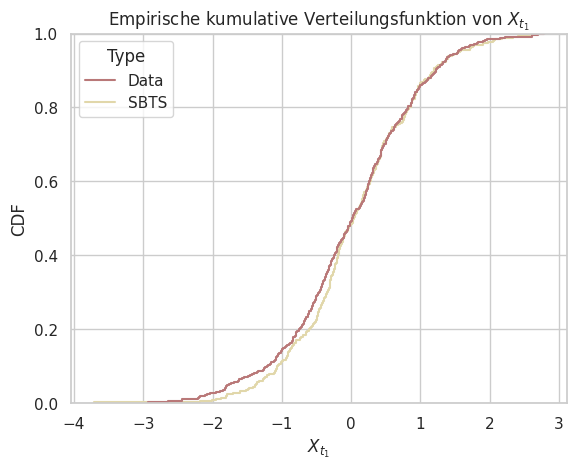

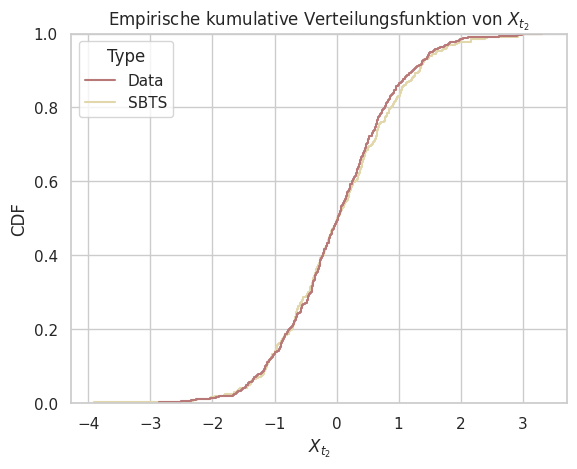

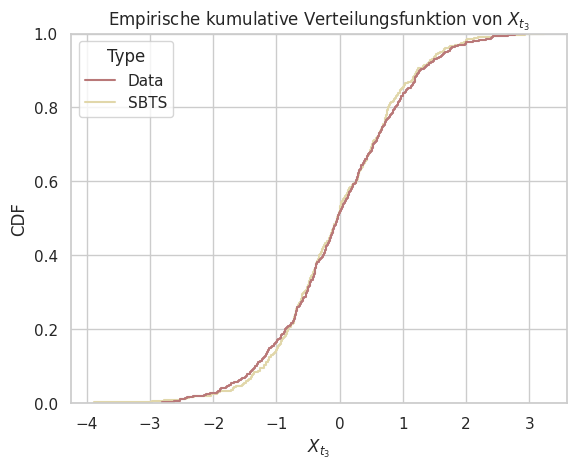

In [231]:


variables = ['X_1', 'X_2', 'X_3']
latex_labels = ['$X_{t_1}$', '$X_{t_2}$', '$X_{t_3}$']

for var, label in zip(variables, latex_labels):
    plt.figure()
    sns.ecdfplot(data=df, x=var, hue='Type', stat='proportion', palette='pink')
    plt.title(f'Empirische kumulative Verteilungsfunktion von {label}')
    plt.xlabel(label)
    plt.ylabel('CDF')
    plt.grid(True)
    labels = [r"$X_{t_1}$", r"$X_{t_2}$", r"$X_{t_3}$"]
    n = len(labels)  
    plt.show()


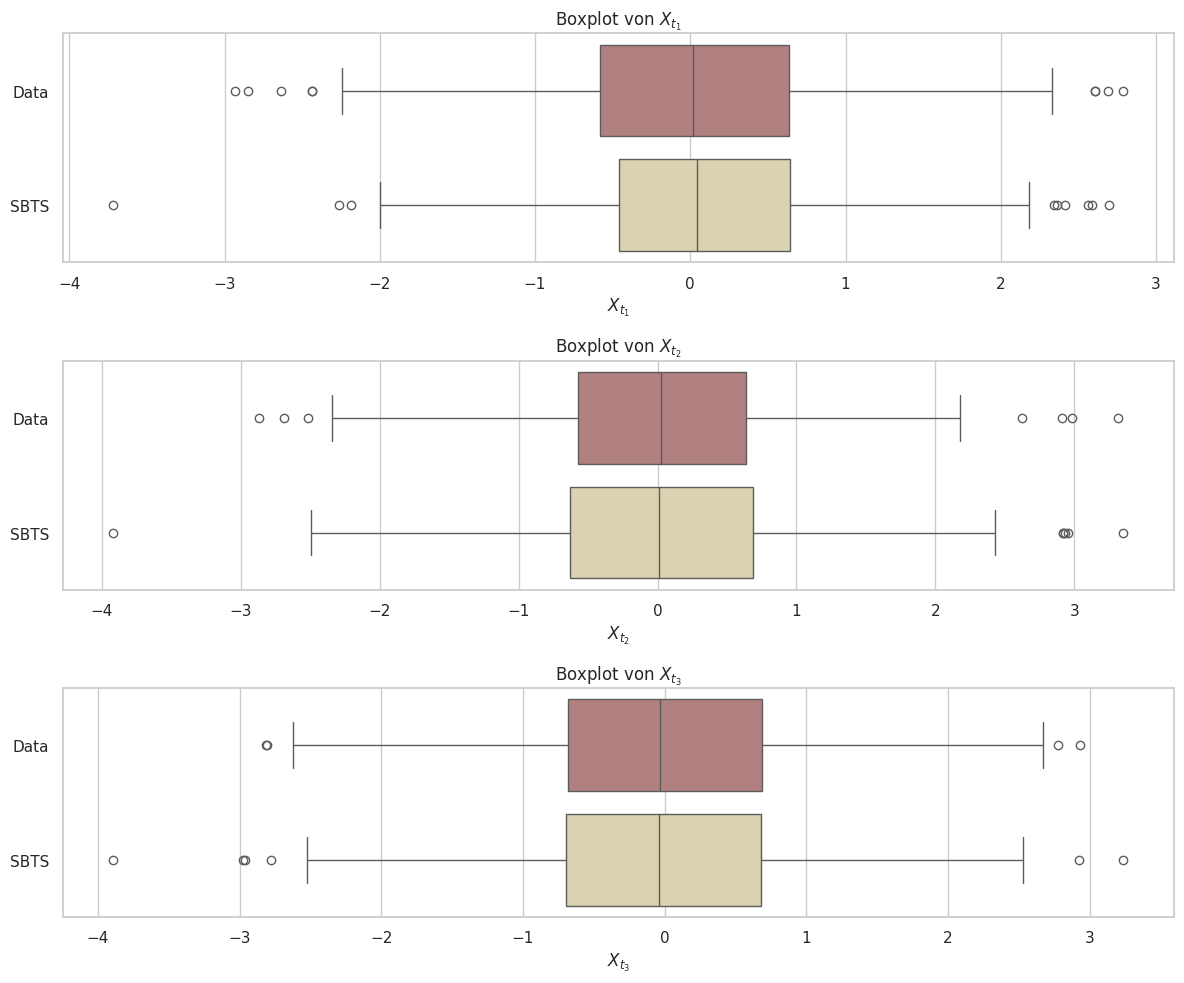

In [228]:

sns.set(style="whitegrid")


plt.figure(figsize=(12, 10))

# Boxplot  X_1
plt.subplot(3, 1, 1)  # 3 Zeilen, 1 Spalte, 1. Position
sns.boxplot(data=df, x='X_1', y='Type', orient='h', palette='pink')
plt.xlabel('$X_{t_1}$')
plt.ylabel('')
plt.title('Boxplot von $X_{t_1}$')

# Boxplot  X_2
plt.subplot(3, 1, 2)  # 3 Zeilen, 1 Spalte, 2. Position
sns.boxplot(data=df, x='X_2', y='Type', orient='h', palette='pink')
plt.xlabel('$X_{t_2}$')
plt.ylabel('')
plt.title('Boxplot von $X_{t_2}$')

# Boxplot  X_3
plt.subplot(3, 1, 3)  # 3 Zeilen, 1 Spalte, 3. Position
sns.boxplot(data=df, x='X_3', y='Type', orient='h', palette='pink')
plt.xlabel('$X_{t_3}$')
plt.ylabel('')
plt.title('Boxplot von $X_{t_3}$')


plt.tight_layout()
plt.show()


### Kolmogorow-Smirnow-Test



1. Der Kolmogorov-Smirnov-Test wird zwischen den Daten `X[:,i]` und den simulierten Daten `simu[:,i]` durchgeführt, und der p-Wert wird im entsprechenden Eintrag von `df_stats_quantiles['p-value']` gespeichert.

2. Die 5%- und 95%-Quantile werden für die Daten `X[:,i]` und die simulierten Daten `simu[:,i]` berechnet und in den entsprechenden Einträgen von `df_stats_quantiles` gespeichert.


In [45]:
df_stats_quantiles = pd.DataFrame(
    columns=[
    "p-value", 
    "5%-quantile data", 
    "5%-quantile SB", 
    "95%-quantile data", 
    "95%-quantile SB"
    ],
    index=[1,2,3]
)

In [46]:
for i in df_stats_quantiles.index:
    
    # Kolmogorov Smirnov test
    df_stats_quantiles['p-value'].loc[i] = kstest(rvs=X[:,i], cdf=simu[:,i])[1]
    
    # Quantiles
    df_stats_quantiles['5%-quantile data'].loc[i] = np.quantile(X[:,i], 0.05)
    df_stats_quantiles['95%-quantile data'].loc[i] = np.quantile(X[:,i], 0.95)
    df_stats_quantiles['5%-quantile SB'].loc[i] = np.quantile(simu[:,i], 0.05)
    df_stats_quantiles['95%-quantile SB'].loc[i] = np.quantile(simu[:,i], 0.95)

In [47]:
df_stats_quantiles

,p-value,5%-quantile data,5%-quantile SB,95%-quantile data,95%-quantile SB
1,0.31368,-1.731686,-1.45147,1.610515,1.483423
2,0.913689,-1.597924,-1.421737,1.610322,1.608243
3,0.954219,-1.65428,-1.535093,1.652781,1.695237


Berechnung der Korrelationsmatrizen für die Daten und die simulierten Daten, sowie die Differenz zwischen ihnen:

In [48]:
data_correlation_matrix = np.corrcoef(X[:,1:].T)
SB_correlation_matrix = np.corrcoef(simu[:,1:].T)

data_correlation_df = pd.DataFrame(data_correlation_matrix)
SB_correlation_df = pd.DataFrame(SB_correlation_matrix)
difference_df = pd.DataFrame((data_correlation_matrix - SB_correlation_matrix).round(3))

combined_df = pd.concat([data_correlation_df, SB_correlation_df, difference_df], axis=1)
combined_df

,0,1,2,0,1,2,0,1,2
0,1.000000,0.458288,0.183726,1.000000,0.453772,0.197479,-0.000,0.005,-0.014
1,0.458288,1.000000,0.489302,0.453772,1.000000,0.502375,0.005,-0.000,-0.013
2,0.183726,0.489302,1.000000,0.197479,0.502375,1.000000,-0.014,-0.013,0.000


## Generierung von GARCH-Zeitreihen

In diesem Abschnitt wird ein GARCH-Modell verwendet, um Zeitreihen zu generieren. Ein GARCH-Modell (Generalized Autoregressive Conditional Heteroskedasticity) ist ein statistisches Modell für die Volatilität von Finanzzeitreihen.

### GARCH-Modell

Wir betrachten ein GARCH-Modell mit den folgenden Parametern:
- $ X_{t+1} = \sigma_{t+1} \epsilon_{t+1} $
- $ \sigma^2_{t+1} = \alpha_0 + \alpha_1 X^2_t + \alpha_2 X^2_{t-1} $
- $ \alpha_0 = 2 $, $ \alpha_1 = -0.4 $, $ \alpha_2 = 0.1 $
- Die Rauschkomponenten $ \epsilon_{t} $ sind unabhängig und identisch normalverteilt mit einem Mittelwert von 0 und einer Standardabweichung von 0.1.

### Generierung von Zeitreihen

Die Größe der Zeitreihen beträgt $ N = 60 $. Um eine stationäre Verteilung zu erreichen, werden zunächst 50 Schritte durchlaufen, bevor die eigentliche Zeitreihe beginnt.

### Hyperparameter

Für das Training und die Generierung von SBTS (Schrödinger Bridge Time Series) werden die folgenden Hyperparameter verwendet:
- Anzahl der Zeitreihen: $ M = 1000 $
- Anzahl der Schritte für die Euler-Diskretisierung: $ N_{\pi} = 100 $
- Bandbreite für die Kernel-Schätzung: $ h = 0.2 $ (größer als für das AR-Modell, da der GARCH-Prozess von Natur aus volatiler ist).


In [232]:
# Number of time steps and number of samples
M = 1000
N = 60

# Generate Garch time series
alpha_0 = 2.
alpha_1 = -0.4
alpha_2 = 0.1

def Garch_sample(alpha_0, alpha_1, alpha_2):
    
    time_series = list()
    x_next = 0.0
    x_prev = 0.0
    
    for t in range(N+50):
        
        # Diffuse over (for example) 50 time steps to achieve stationarity
        if t>=50:
            time_series.append(x_next)
        
        # Compute volatility
        sigma = np.sqrt(alpha_0 + alpha_1 * x_next**2 + alpha_2 * x_prev**2)
        x_prev = x_next
        x_next = sigma * np.random.normal(scale=0.1)
        
    return [0.0] + time_series

XGarch = np.array([Garch_sample(alpha_0, alpha_1, alpha_2) for i in range(M)])

M, N, XGarch.shape

(1000, 60, (1000, 61))

In [233]:
simuGarch = simulateSB(
    N = N, 
    M = M,
    Data = XGarch, 
    deltati = 7./252., 
    H = 0.2, 
    nbStepsPerDeltati = 100, 
    numberOfSamples = 1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [234]:
def plot_random_paths(simu_data, X_data, num_paths=4, figsize=(14, 6), colors=['red', 'blue', 'green', 'purple'], titles=None, ylabels=None):
    """
    Plots randomly selected paths from two datasets side by side.
    
    Parameters:
    - simu_data: numpy array, simulated data
    - X_data: numpy array, actual data
    - num_paths: int, number of random paths to select and plot
    - figsize: tuple, size of the figure
    - colors: list, colors for the paths
    - titles: list, titles for the subplots
    - ylabels: list, y-axis labels for the subplots
    """
    # Randomly select indices
    random_indices = np.random.choice(simu_data.shape[0], num_paths, replace=False)
    
    # Extract the paths
    selected_simu_paths = simu_data[random_indices, :]
    selected_X_paths = X_data[random_indices, :]
    
    # Create subplots with shared y-axis
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    
    # Plot for the first dataset
    for i, path in enumerate(selected_X_paths):
        axes[0].plot(path, label=f'Pfad {random_indices[i]+1}', color=colors[i])
    axes[0].set_xlabel('Zeit')
    axes[0].set_ylabel(ylabels[0])
    axes[0].legend(title='Pfad')
    if titles:
        axes[0].set_title(titles[0])
    
    # Plot for the second dataset
    for i, path in enumerate(selected_simu_paths):
        axes[1].plot(path, label=f'Pfad {random_indices[i]+1}', color=colors[i])
    axes[1].set_xlabel('Zeit')
    axes[1].set_ylabel(ylabels[1])
    axes[1].legend(title='Pfad')
    if titles:
        axes[1].set_title(titles[1])
    
    plt.tight_layout()
    plt.show()

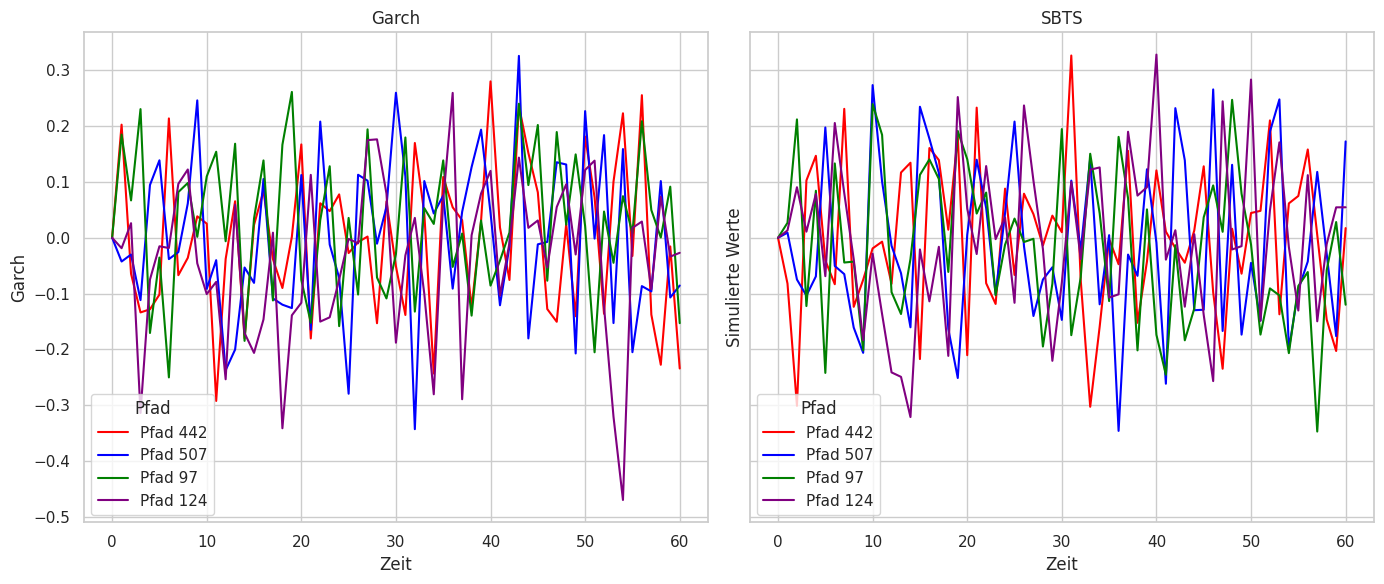

In [238]:
# Assuming simu and X are your data arrays
plot_random_paths(
    simu_data=simuGarch,
    X_data=XGarch,
    titles=['Garch', 'SBTS'],
    ylabels=['Garch', 'Simulierte Werte']
)

### Echte Daten von yfinance

#### Herunterladen von Daten mit der Yahoo Finance API

Die Daten für das Unternehmen Microsoft werden von Yahoo Finance heruntergeladen. Der Datumsbereich erstreckt sich von Januar 2010 bis Januar 2020.

#### Erstellung von vielen Beispielen der Microsoft-Zeitreihe

Es wird ein rollendes Fenster verwendet, um viele Beispiele der Apple-Zeitreihe zu erstellen. Die Fenstergröße beträgt $N = 60$. Die relative Veränderung der Anpassungsschlusskurse wird verwendet.

#### Schrödinger-Brücken-Diffusion der logarithmischen Renditen

Die logarithmischen Renditen der Aktienkurse werden berechnet und dann die Schrödinger-Brücken-Diffusion auf die logarithmischen Renditen angewendet. Die Hyperparameter für die Erzeugung der synthetischen SBTS-Proben sind $N^{\pi} = 100$ und eine Bandbreite von $H = 0.05$.

#### Konvertierung der logarithmischen Renditen

Die simulierten logarithmischen Renditen werden in absolute Preise umgerechnet, indem sie aufsummiert und dann exponentiert werden. Danach werden die Pfade dargestellt.


In [239]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [240]:
# Download data using Yahoo Finance API
start_date = "2010-01-01"
end_date = "2020-01-30"
data = pdr.get_data_yahoo("MSFT", start=start_date, end=end_date)

# Take rolling window to create many samples of apple time series
N = 60
X = np.array([data["Adj Close"].values[i:i+N+1]/data["Adj Close"].values[i] for i in range(len(data)-N)])
M = len(X)

# Get log returns
log_returns = np.zeros((M, N+1))
log_returns[:,1:] = np.diff(np.log(X), axis=1)

[*********************100%%**********************]  1 of 1 completed


In [241]:
# SBTS diffusion of log returns
simu_log_returns = simulateSB(
    N = N, 
    M = log_returns.shape[0],
    Data = log_returns,
    deltati = 2./252.,
    H = 0.05, 
    nbStepsPerDeltati = 100, 
    numberOfSamples = 1000
)

# Convert log returns
simu = np.exp(simu_log_returns.cumsum(axis=1))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [242]:
log_returns.shape

(2475, 61)

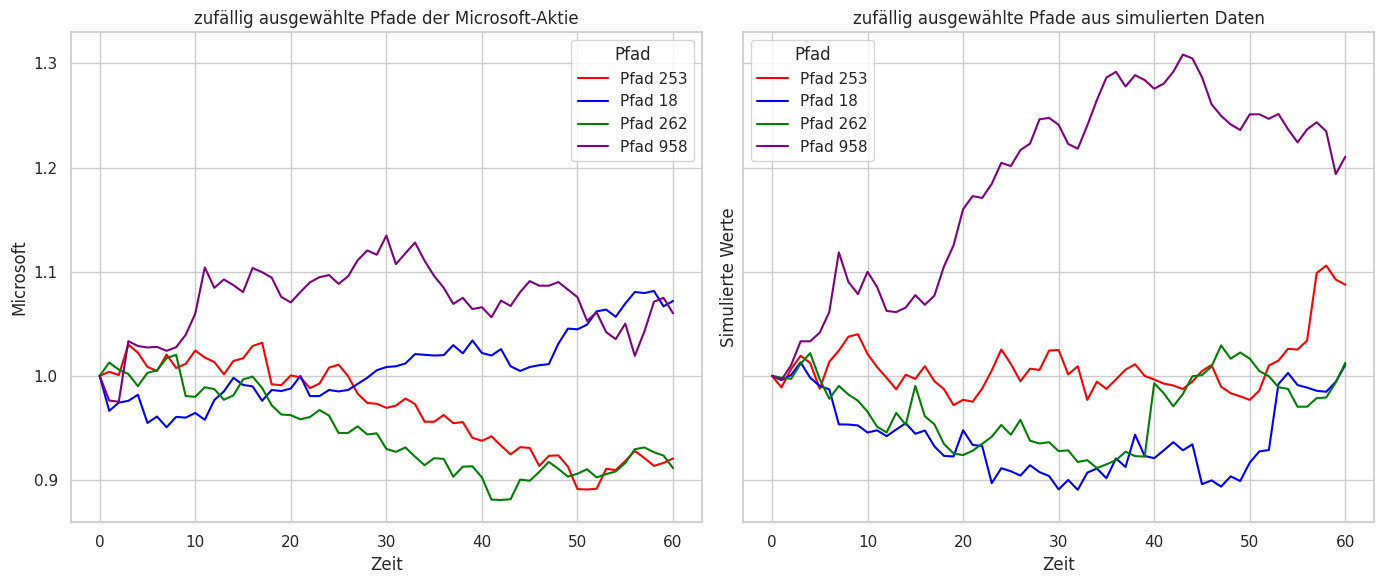

In [243]:
plot_random_paths(
    simu_data=simu,
    X_data=X,
    titles=['zufällig ausgewählte Pfade der Microsoft-Aktie', 'zufällig ausgewählte Pfade aus simulierten Daten'],
    ylabels=['Microsoft', 'Simulierte Werte']
)

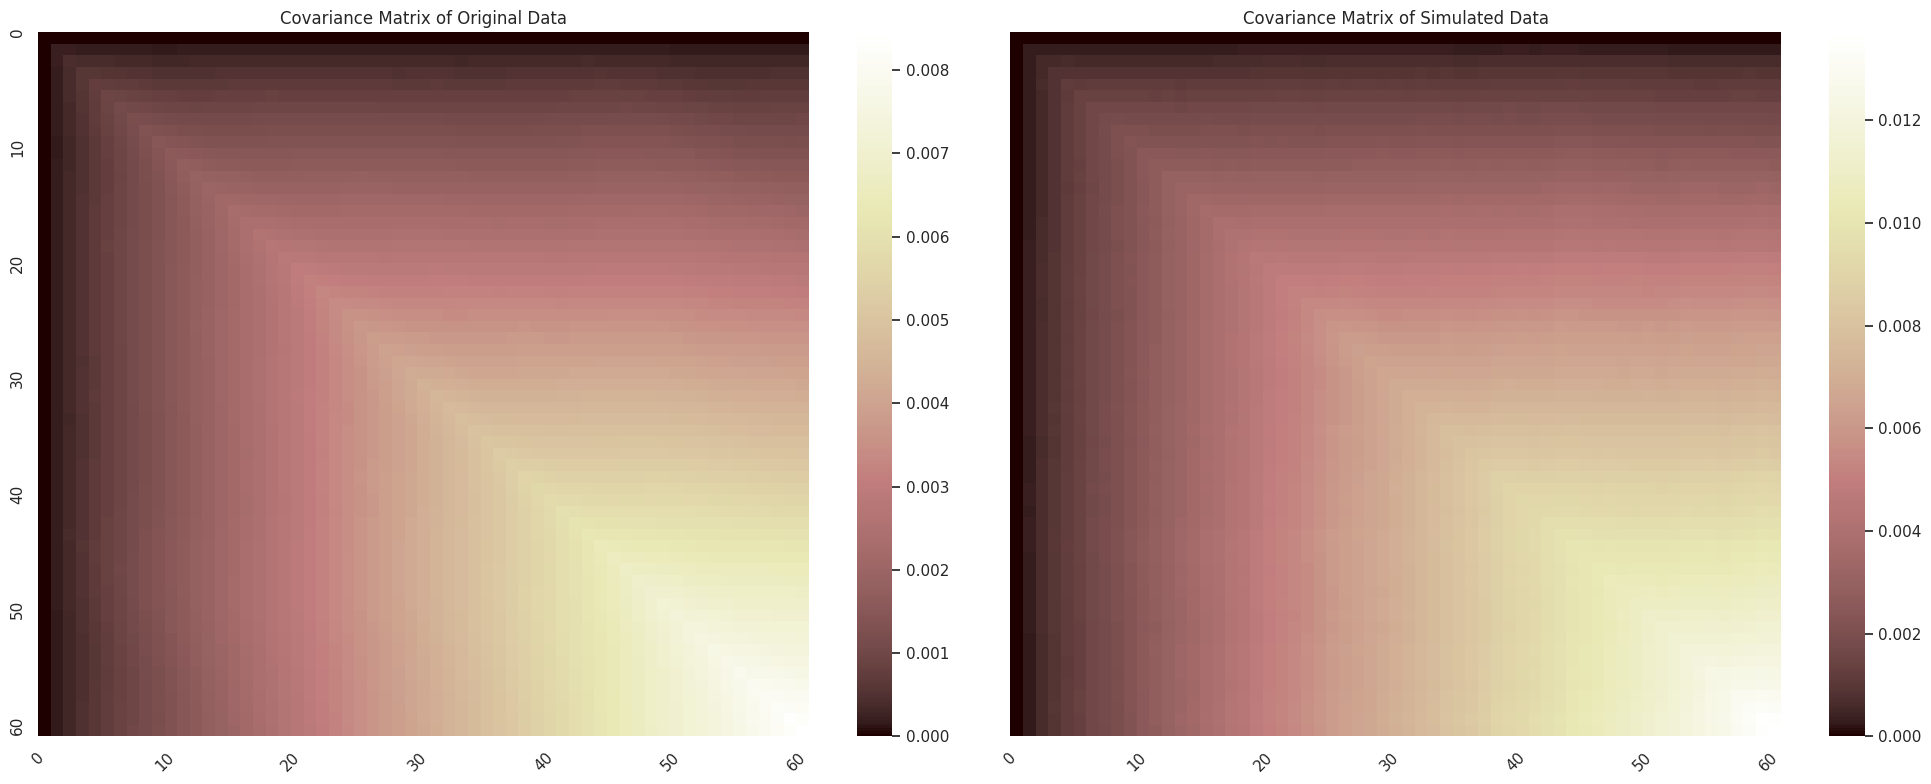

In [244]:
# Compute the covariance matrices
cov_simu = np.cov(simu, rowvar=False)
cov_X = np.cov(X, rowvar=False)

def plot_covariance_matrices(cov_matrix1, cov_matrix2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

    # Plot the first covariance matrix
    sns.heatmap(cov_matrix1, annot=False, cmap='pink',  ax=axes[0])
    axes[0].set_title(title1)
    num_vars1 = cov_matrix1.shape[0]
    ticks1 = np.arange(0, num_vars1, 10)
    labels1 = [str(i) for i in ticks1]
    axes[0].set_xticks(ticks1)
    axes[0].set_xticklabels(labels1, rotation=45)
    axes[0].set_yticks(ticks1)
    axes[0].set_yticklabels(labels1)

    # Plot the second covariance matrix
    sns.heatmap(cov_matrix2, annot=False, cmap='pink',  ax=axes[1])
    axes[1].set_title(title2)
    num_vars2 = cov_matrix2.shape[0]
    ticks2 = np.arange(0, num_vars2, 10)
    labels2 = [str(i) for i in ticks2]
    axes[1].set_xticks(ticks2)
    axes[1].set_xticklabels(labels2, rotation=45)
    axes[1].set_yticks(ticks2)
    axes[1].set_yticklabels(labels2)

    plt.tight_layout()
    plt.show()


# Plot the covariance matrices side by side
plot_covariance_matrices(cov_X, cov_simu, 'Covariance Matrix of Original Data', 'Covariance Matrix of Simulated Data')

In [245]:
def calculate_quadratic_variation(data):
    # Calculate the increments
    increments = np.diff(data, axis=1)
    # Calculate the squared increments
    squared_increments = increments ** 2
    # Sum the squared increments to get the quadratic variation
    quadratic_variation = np.sum(squared_increments, axis=1)
    return quadratic_variation

quad_var_simu = calculate_quadratic_variation(simu)
quad_var_X = calculate_quadratic_variation(X)


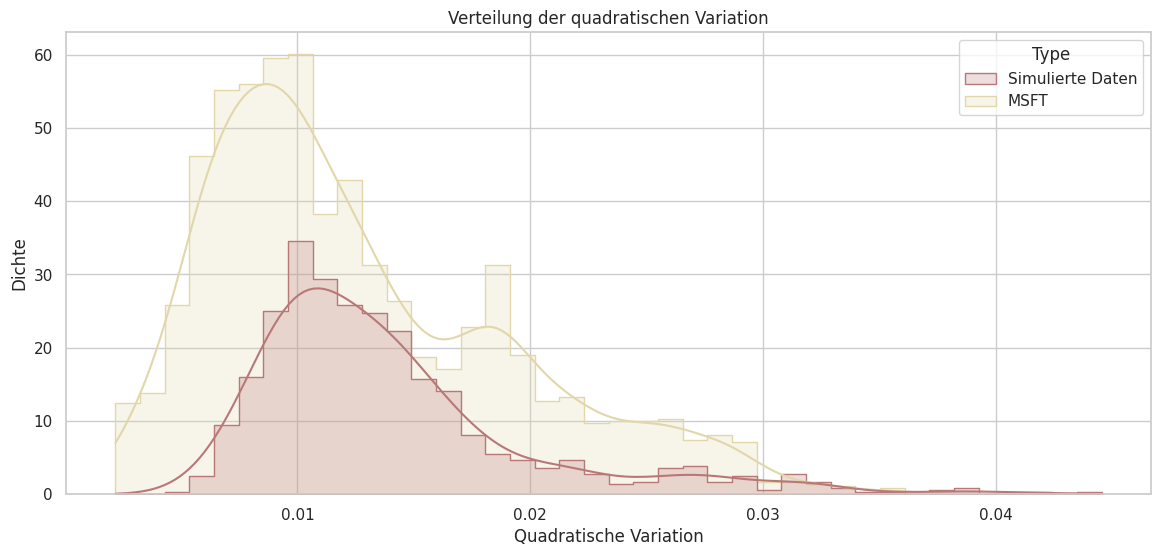

In [246]:
# Create DataFrames for each
df_quad_var_simu = pd.DataFrame({
    'Quadratic Variation': quad_var_simu,
    'Type': 'Simulierte Daten'
})

df_quad_var_X = pd.DataFrame({
    'Quadratic Variation': quad_var_X,
    'Type': 'MSFT'
})

# Combine the DataFrames
df_quad_var_combined = pd.concat([df_quad_var_simu, df_quad_var_X])

# Plot the distribution of quadratic variation
plt.figure(figsize=(14, 6))
sns.histplot(data=df_quad_var_combined, x='Quadratic Variation', hue='Type', kde=True, element='step', palette='pink', stat='density')
plt.title('Verteilung der quadratischen Variation')
plt.xlabel('Quadratische Variation')
plt.ylabel('Dichte')
plt.show()

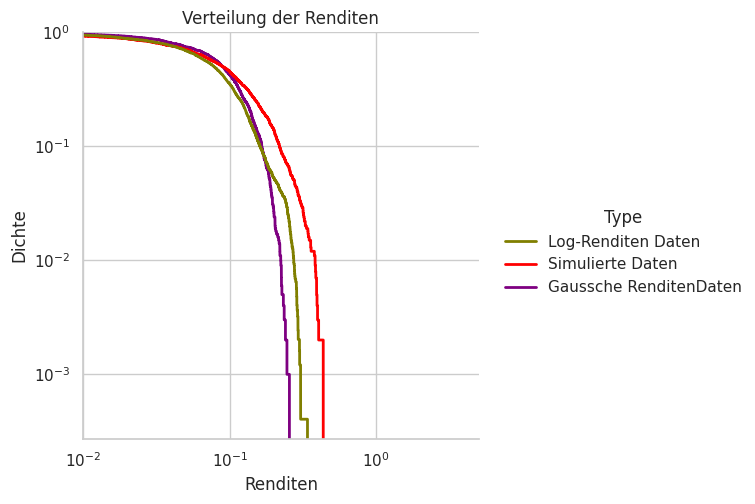

In [247]:
#Returns
simu_returns = np.abs(np.array(simu)[:,-1] - np.array(simu)[:,0])
X_returns = np.abs(np.array(X)[:,-1] - np.array(X)[:,0])
gaussian_returns = np.abs(np.random.normal(loc=np.mean(X_returns), scale=np.std(X_returns), size=M_max))


# Create DataFrames for plotting
df_returns_simu = pd.DataFrame({
    'Returns': simu_returns,
    'Type': 'Simulierte Daten'
})

df_returns_X = pd.DataFrame({
    'Returns': X_returns,
    'Type': 'Log-Renditen Daten'
})

df_returns_gaussian = pd.DataFrame({
    'Returns': gaussian_returns,
    'Type': 'Gaussche RenditenDaten'
})
# Combine the DataFrames
df_returns_combined = pd.concat([df_returns_X, df_returns_simu, df_returns_gaussian])

# Plot the distribution of returns
sns.displot(data=df_returns_combined, x="Returns", hue="Type", complementary=True, kind="ecdf", palette="brg_r", linewidth=2)
plt.title('Verteilung der Renditen')
plt.xlabel('Renditen')
plt.ylabel('Dichte')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,5)
plt.show()


In [249]:
Path("../data/").mkdir(parents=True, exist_ok=True)

if os.path.exists("../data/data_deephedging.npz"):
    
    print("data already exists")
    
else:

    simu_log_returns = simulateSB(
        N = N, 
        M = log_returns.shape[0],
        Data = log_returns,
        deltati = 2./252.,
        H = 0.05, 
        nbStepsPerDeltati = 100, 
        numberOfSamples = 10000
    )

    simu = np.exp(simu_log_returns.cumsum(axis=1))
    
    np.savez_compressed("../data/data_deephedging.npz", X=X, simu=simu)

data already exists
